In [1]:
# Trafic Engineering

In [2]:
import pandas as pd
from pandas import Series, DataFrame

In [3]:
df = pd.read_csv("spend.csv")
df.head()

,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
0,50 - LIBRARY,50100 - LIB PUBLIC SERVICE,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-11355535.00,-11941627.00,-12603779.00,-13080447.90
1,50 - LIBRARY,50300 - LIB COL RES & ACCESS,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-2056164.00,-2222626.00,-2199357.00,-2268968.77
2,50 - LIBRARY,50400 - LIB FACILITIES,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-1766869.00,-1768986.00,-1963404.00,-1976738.18
3,51 - PARKS,51220 - PARK MTC FORESTRY GENERAL,Revenue,49 - TRANSFER IN,49124 - TRANSFER IN FROM OTHER RESTRIC,-1000000.00,-2500000.00,-3100342.25,0.00
4,44 - STREETS,44220 - ST RECYCLING COLLECTION,Revenue,43 - CHARGES FOR SERVICES,43445 - SALE OF RECYCLABLES,-841012.69,-866760.77,-1218608.41,-892803.25


In [4]:
# df = df.rename(index=str, columns = {" 2015 ": "2015", " 2016 ": "2016", " 2017 ": "2017", " 2018 ": "2018"})

In [5]:
s_rev15 = df['2015'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Revenue')]
rev15 = s_rev15.sum()
rev15

-618912.89

In [6]:
s_exp15 = df['2015'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Expense')]
exp15 = s_exp15.sum()
exp15

7153602.45

In [7]:
s_rev16 = df['2016'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Revenue')]
rev16 = s_rev16.sum()
rev16

-1246813.4500000002

In [8]:
s_exp16 = df['2016'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Expense')]
exp16 = s_exp16.sum()
exp16

7056788.83

In [9]:
s_rev17 = df['2017'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Revenue')]
rev17 = s_rev17.sum()
rev17

-1366140.23

In [10]:
s_exp17 = df['2017'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Expense')]
exp17 = s_exp17.sum()
exp17

7397270.73

In [11]:
s_rev18 = df['2018'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Revenue')]
rev18 = s_rev18.sum()
rev18

-937656.47

In [12]:
s_exp18 = df['2018'][(df['Agency'] == '45 -  TRAFFIC ENGINEERING') & (df['Account Type'] == 'Expense')]
exp18 = s_exp18.sum()
exp18

7093302.779999999

In [13]:
df_graph = DataFrame({'Year': ['2015', '2016', '2017', '2018'], 'Revenue': [rev15, rev16, rev17, rev18], 'Expense': [exp15, exp16, exp17, exp18]})
df_graph = df_graph.set_index('Year')

In [14]:
%matplotlib inline

In [15]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

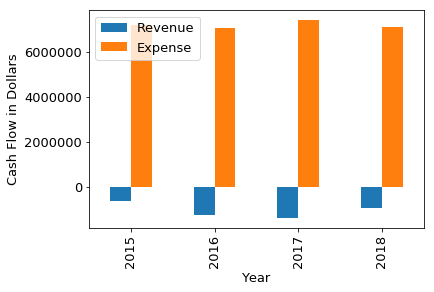

In [18]:
ax = df_graph.plot.bar()
ax.set_ylabel('Cash Flow in Dollars')
None